In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import string
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import seaborn as sns
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
def generate_dictionaries(D):
    """
    Génère les dictionnaires char<->id et char<->embedding pour k lettres + un token vide.
    """


    letters = [chr(ord('A') + i) for i in range(D)]
    dim = D
    basis = np.eye(dim)  # Embeddings orthogonaux
    char_to_embed = {char: basis[i] for i, char in enumerate(letters)}
    letters.append('_')  # Ajout du token vide  

    char_to_id = {char: i for i, char in enumerate(letters)}

    id_to_char = {i: char for char, i in char_to_id.items()}


    return char_to_id, id_to_char, char_to_embed
    

In [9]:
def generate_sequences(n, T, D):
    assert 1 <= D <= 26, "k doit être entre 1 et 26"
    alphabet = list(string.ascii_uppercase[:D])
    sequences = []

    for i in range(n):
        possible_letters = random.choices(alphabet, k=3)
        sequences.append(random.choices(possible_letters, k=T))
    return sequences

In [10]:
generate_sequences(10, 5, 25)

[['U', 'X', 'X', 'X', 'X'],
 ['Y', 'W', 'Y', 'W', 'G'],
 ['L', 'K', 'K', 'K', 'K'],
 ['U', 'X', 'F', 'F', 'X'],
 ['Y', 'G', 'Y', 'G', 'G'],
 ['J', 'C', 'J', 'C', 'C'],
 ['B', 'I', 'B', 'B', 'I'],
 ['S', 'S', 'M', 'M', 'S'],
 ['X', 'K', 'S', 'S', 'S'],
 ['O', 'U', 'O', 'U', 'I']]

In [11]:
def get_y_seq(seq):
    """
    Pour chaque position t, renvoie la lettre qui suit la dernière occurrence
    de seq[t], s'il y en a une, sinon '_'.
    """
    y_seq = ['_'] * len(seq)  # Valeur par défaut
    last_seen = {}  # Dictionnaire pour enregistrer la dernière position de chaque lettre

    for t, letter in enumerate(seq):
        if letter in last_seen:
            prev_index = last_seen[letter]
            if prev_index + 1 < len(seq):
                y_seq[t] = seq[prev_index + 1]
        last_seen[letter] = t  # Mise à jour de la dernière position

    return y_seq



In [12]:
def get_X_y(n, T, D):
    """
    Génère un dataset de n séquences de longueur T avec D lettres.
    Retourne :
    - X_seq : liste de n séquences de lettres (chacune de longueur T)
    - X_emb : np.array de shape (n, T, D), avec les embeddings orthogonaux
    - y_seq : liste de n séquences cibles (chacune de longueur T)
    - y_id  : np.array de shape (n, T), avec les indices correspondants
    """
    import numpy as np
    import string
    import random

    char_to_id, id_to_char, char_to_embed = generate_dictionaries(D)
    sequences = generate_sequences(n, T, D)

    X_seq = sequences
    y_seq = [get_y_seq(seq) for seq in sequences]

    # Embeddings et ids
    X_emb = np.array([
        [char_to_embed[c] for c in seq] for seq in X_seq
    ])  # shape (n, T, D)

    y_id = np.array([
        [char_to_id[c] for c in y] for y in y_seq
    ])  # shape (n, T)

    return X_seq, X_emb, y_seq, y_id, char_to_id, id_to_char, char_to_embed


In [47]:
T = 3
D = 9
n = 100000

In [48]:
X_seq, X_emb, y_seq, y_id, char_to_id, id_to_char, char_to_embed = get_X_y(n=n, T=T, D=D)

In [49]:
X = torch.tensor(X_emb).float()
y = torch.tensor(y_id).long()

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
def token_accuracy(preds, targets):
    """
    Calcule l'accuracy lettre par lettre (token par token).
    """
    pred_classes = torch.argmax(preds, dim=-1)  # [B, T]
    correct = (pred_classes == targets).float()
    return correct.mean().item()

def train_model(model, train_loader, test_loader, epochs=10, lr=1e-3, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()  # attente [B, C, T] vs [B, T]

    train_loss_list = []
    test_loss_list = []
    test_acc_list = []

    for epoch in range(1, epochs + 1):
        model.train()
        total_train_loss = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)  # xb: [B, T, D], yb: [B, T]
            preds = model(xb)                      # preds: [B, T, C]
            preds = preds.permute(0, 2, 1)         # -> [B, C, T] pour CrossEntropy
            loss = criterion(preds, yb)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_list.append(loss.item())
            total_train_loss += loss.item()

        # 🔍 Validation à la fin de l'epoch
        model.eval()
        total_val_loss = 0
        total_acc = 0
        total_samples = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_loss = criterion(preds.permute(0, 2, 1), yb)
                total_val_loss += val_loss.item()
                test_loss_list.append(val_loss.item())

                acc = token_accuracy(preds, yb)
                total_acc += acc * xb.size(0)
                total_samples += xb.size(0)

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(test_loader)
        avg_val_acc = total_acc / total_samples
        test_acc_list.append(avg_val_acc)

        print(f"Epoch {epoch}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")

    return train_loss_list, test_loss_list, test_acc_list



In [52]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # [1, max_len, d_model]

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].to(x.device)
        return x
class LearnedPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        self.pos_embed = nn.Embedding(max_len, d_model)

    def forward(self, x):
        seq_len = x.size(1)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0)  # [1, seq_len]
        return x + self.pos_embed(positions)  # broadcast sur batch



class AttentionOnlyBlock(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wk = nn.Linear(d_model, d_model, bias=False)
        self.Wv = nn.Linear(d_model, d_model, bias=False)
        self.norm = nn.LayerNorm(d_model)
        self.attn_weights = None  # <-- pour garder la dernière attention

    def forward(self, x):
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)
        attn_scores = torch.matmul(Q, Q.transpose(-2, -1)) / (Q.size(-1) ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        self.attn_weights = attn_weights.detach().cpu()  # stocker pour affichage

        attn_output = torch.matmul(attn_weights, V)
        return self.norm(attn_output )

class AttentionOnlyTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=128, num_layers=2, max_len=100):
        super().__init__()
        self.embedding_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([AttentionOnlyBlock(d_model) for _ in range(num_layers)])
        self.classifier = nn.Linear(d_model, num_classes)
    def init_first_layer_qk_identity(self):
        """
        Initialise Wq et Wk de la première couche à l'identité.
        """
        first_layer = self.layers[0]
        d_model = first_layer.Wq.weight.size(0)
        with torch.no_grad():
            first_layer.Wq.weight.copy_(torch.eye(d_model))
            first_layer.Wk.weight.copy_(torch.eye(d_model))
            # Freeze gradients
        first_layer.Wq.weight.requires_grad = False
        first_layer.Wk.weight.requires_grad = False


    def forward(self, x):
        x = self.embedding_proj(x)
        x = self.pos_encoder(x)
        for layer in self.layers:
            x = layer(x)
        return self.classifier(x)

In [53]:
n_layers = 2

In [57]:
model = AttentionOnlyTransformer(input_dim=D, num_classes=D+1, d_model=256, num_layers=n_layers, max_len=T)



In [58]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=300, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [59]:
train_loss_list, test_loss_list, test_acc_list = train_model(model, train_loader, test_loader, epochs=50, lr=1e-4, device=device)

Epoch 1/50 | Train Loss: 0.8054 | Val Loss: 0.6002 | Val Acc: 0.7166
Epoch 2/50 | Train Loss: 0.5945 | Val Loss: 0.5922 | Val Acc: 0.7166
Epoch 3/50 | Train Loss: 0.4442 | Val Loss: 0.2023 | Val Acc: 0.9484
Epoch 4/50 | Train Loss: 0.1510 | Val Loss: 0.1269 | Val Acc: 0.9471
Epoch 5/50 | Train Loss: 0.1141 | Val Loss: 0.1032 | Val Acc: 0.9507
Epoch 6/50 | Train Loss: 0.1055 | Val Loss: 0.0960 | Val Acc: 0.9541
Epoch 7/50 | Train Loss: 0.0991 | Val Loss: 0.0861 | Val Acc: 0.9544
Epoch 8/50 | Train Loss: 0.0938 | Val Loss: 0.0815 | Val Acc: 0.9621
Epoch 9/50 | Train Loss: 0.0824 | Val Loss: 0.1162 | Val Acc: 0.9376
Epoch 10/50 | Train Loss: 0.0535 | Val Loss: 0.0101 | Val Acc: 1.0000
Epoch 11/50 | Train Loss: 0.0032 | Val Loss: 0.0012 | Val Acc: 1.0000
Epoch 12/50 | Train Loss: 0.0008 | Val Loss: 0.0005 | Val Acc: 1.0000


KeyboardInterrupt: 

In [60]:
def show_colored_predictions_on_dataset(model, X, y, id_to_char, char_to_id, max_samples=5, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Affiche les prédictions du modèle sur un dataset donné (X, y).
    Colore en vert les bonnes prédictions, en rouge les erreurs.
    Affiche aussi la lettre à utiliser pour les remplacements après les 'A'.
    
    Args:
        model: le modèle entraîné
        X: tenseur [B, T, D]
        y: tenseur [B, T]
        id_to_char: dictionnaire id -> lettre
        char_to_id: dictionnaire lettre -> id
        max_samples: nombre de séquences à afficher
    """
    model.eval()
    with torch.no_grad():
        X = X.to(device)
        y = y.to(device)
        preds = torch.argmax(model(X), dim=-1)  # [B, T]

    for i in range(min(max_samples, X.shape[0])):
        x_ids = torch.argmax(X[i], dim=-1).cpu().numpy()
        input_seq = [id_to_char[idx] for idx in x_ids]
        true_seq = [id_to_char[idx] for idx in y[i].cpu().numpy()]
        pred_seq = [id_to_char[idx] for idx in preds[i].cpu().numpy()]

        # Trouver la lettre de remplacement après le premier 'A' s’il y a lieu
        A_indices = [j for j, c in enumerate(input_seq) if c == 'A']
        substitution_letter = "-"
        if len(A_indices) >= 2 and A_indices[0] + 1 < len(input_seq):
            substitution_letter = input_seq[A_indices[0] + 1]

        print(f"\n🔄 Replacement letter after first 'A': {substitution_letter}")
        print("📝 Input sequence  : ", end="")
        for c in input_seq:
            print(f"{c:>3}", end="")
        print()

        print("🎯 Expected output : ", end="")
        for t, p in zip(true_seq, pred_seq):
            color = "\033[92m" if t == p else "\033[91m"
            print(f"{color}{t:>3}\033[0m", end="")
        print()

        print("🔮 Model predicts  : ", end="")
        for t, p in zip(true_seq, pred_seq):
            color = "\033[92m" if t == p else "\033[91m"
            print(f"{color}{p:>3}\033[0m", end="")
        print("\n" + "-" * 50)


In [61]:
show_colored_predictions_on_dataset(model, X_test, y_test, id_to_char, char_to_id, max_samples=20)



🔄 Replacement letter after first 'A': -
📝 Input sequence  :   B  B  B
🎯 Expected output :   _  B  B
🔮 Model predicts  :   _  B  B
--------------------------------------------------

🔄 Replacement letter after first 'A': -
📝 Input sequence  :   D  B  H
🎯 Expected output :   _  _  _
🔮 Model predicts  :   _  _  _
--------------------------------------------------

🔄 Replacement letter after first 'A': -
📝 Input sequence  :   I  E  C
🎯 Expected output :   _  _  _
🔮 Model predicts  :   _  _  _
--------------------------------------------------

🔄 Replacement letter after first 'A': -
📝 Input sequence  :   I  I  F
🎯 Expected output :   _  I  _
🔮 Model predicts  :   _  I  _
--------------------------------------------------

🔄 Replacement letter after first 'A': -
📝 Input sequence  :   C  B  C
🎯 Expected output :   _  _  B
🔮 Model predicts  :   _  _  B
--------------------------------------------------

🔄 Replacement letter after first 'A': -
📝 Input sequence  :   E  E  E
🎯 Expected output :

In [62]:
def plot_attention_matrices_with_accuracy(model, sequences, char_to_id, special_char='A', special_value=7, device=device, n_layers=1):
    embeddings = np.eye(D)
    print("embeddings", embeddings)
    model.eval()

    num_sequences = len(sequences)
    fig, axs = plt.subplots(num_sequences, n_layers, figsize=(14, 3.5 * num_sequences))

    if num_sequences == 1:
        axs = [axs]

    for i, sequence in enumerate(sequences):
        # Embedding + entrée
        x_seq = [embeddings[char_to_id[c]] for c in sequence]
        x_tensor = torch.tensor([x_seq], dtype=torch.float32).to(device)

        # Calcul des cibles attendues
        counts = {c: sequence.count(c) for c in char_to_id}
        y_target = torch.tensor([[special_value if c == special_char else counts[c] for c in sequence]], dtype=torch.long).to(device)

        # Prédiction
        with torch.no_grad():
            preds = model(x_tensor).squeeze(0)  # [T, 1]

        k = 100

        for k_layer in range(n_layers):
            attn = F.softmax(model.layers[k_layer].attn_weights, dim=-1).detach().squeeze(0).cpu().numpy()[:k,:k]
            sns.heatmap(attn, cmap="viridis", xticklabels=sequence[:k], yticklabels=sequence[:k], square=True,
                        cbar=True, ax=axs[i][k_layer])
            axs[i][k_layer].set_title(f"Layer {k_layer + 1} ")
            axs[i][k_layer].set_xlabel("Input Sequence")
            axs[i][k_layer].set_ylabel("Attention Weights")
            axs[i][k_layer].set_xticklabels(sequence[:k], rotation=45)
            axs[i][k_layer].set_yticklabels(sequence[:k], rotation=0)




    plt.tight_layout()
    plt.show()
    return fig

In [63]:
def decode_x_to_letters(x_tensor, id_to_char):
    """
    Convertit un tenseur [B, T, D] en liste de séquences de lettres.

    Args:
        x_tensor: tenseur de taille [B, T, D] (one-hot ou proche de one-hot)
        id_to_char: dictionnaire id -> lettre (ex: {0: 'A', 1: 'B', ...})

    Returns:
        List[str]: liste de chaînes de lettres, une par séquence du batch.
    """
    x_ids = torch.argmax(x_tensor, dim=-1).cpu().numpy()  # [B, T]
    sequences = []
    for row in x_ids:
        letters = [id_to_char[i] for i in row]
        sequences.append("".join(letters))
    return sequences


In [64]:
sequences = decode_x_to_letters(X_test[:20], id_to_char)

embeddings [[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]


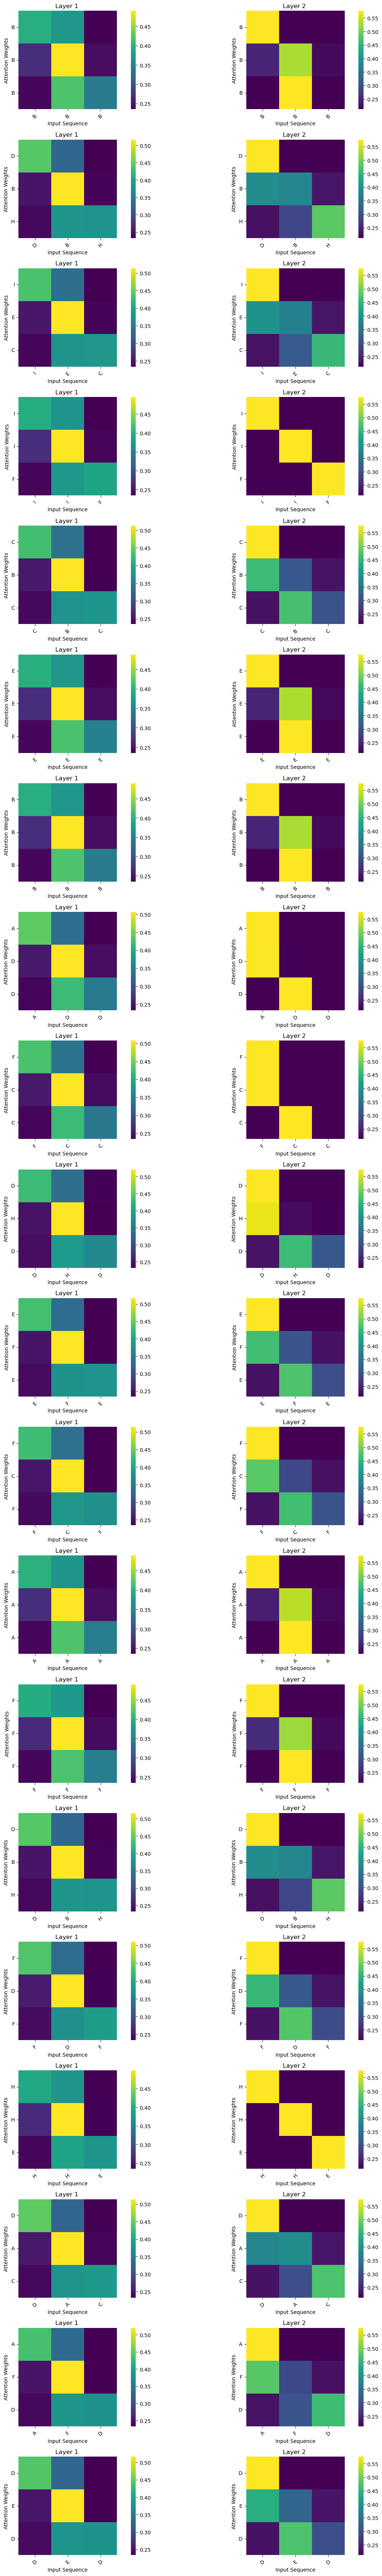

In [65]:
fig = plot_attention_matrices_with_accuracy(model, sequences, char_to_id, special_char='A', special_value=7, device=device, n_layers=n_layers)